# Tabu search

## Preparation

In [1]:
# install.packages(c("bnlearn", "lavaan", "dagitty"))

In [2]:
library("bnlearn")
library("lavaan")
library("dagitty")

Warning message:
"package 'bnlearn' was built under R version 3.6.3"Warning message:
"package 'lavaan' was built under R version 3.6.3"This is lavaan 0.6-7
lavaan is BETA software! Please report any bugs.
Warning message:
"package 'dagitty' was built under R version 3.6.3"
Attaching package: 'dagitty'

The following objects are masked from 'package:bnlearn':

    ancestors, children, descendants, parents, spouses



## Data loading and preprocessing

In [3]:
df <- read.csv('Datasets/Dataset_Coeff_Estimation.csv')

df$Caffeine <- ordered(df$Caffeine, levels =c("0","1","2","3","4","5","6"))
df$Cannabis <- ordered(df$Cannabis, levels =c("0","1","2","3","4","5","6"))
df$Meth <- ordered(df$Meth, levels =c("0","1","2","3","4","5","6"))
df$Age <- ordered(df$Age, levels =c("18-24","25-34","35-44","45-54","55-64","65+"))
df$Education <- ordered(df$Education, levels=c("Left school before 16","Left school at 16","Left school at 17","Left school at 18","College or university dropout","Professional certificate/ diploma","University degree","Masters degree","Doctorate degree"))

# Make sure all other variables are converted to double to get accepted by bnlearn
df$Gender <- as.double(df$Gender) 
df$Nscore <- as.double(df$Nscore) 
df$Escore <- as.double(df$Escore) 
df$Oscore <- as.double(df$Oscore) 
df$Ascore <- as.double(df$Ascore) 
df$Cscore <- as.double(df$Cscore)

## Structure learning

First, we fit the model structure using the Tabu algorithm without specifying any constraints. The model is scored using the BIC metric.


  Bayesian network learned via Score-based methods

  model:
   [Age][Caffeine][Education|Age][Cannabis|Age][Sensation_seeking|Cannabis]
   [Meth|Cannabis][Nscore|Sensation_seeking][Oscore|Sensation_seeking:Cannabis]
   [Gender|Nscore:Sensation_seeking]
   [Escore|Gender:Nscore:Oscore:Sensation_seeking]
   [Cscore|Gender:Nscore:Escore:Sensation_seeking]
   [Ascore|Gender:Nscore:Oscore:Cscore:Sensation_seeking]
   [Impulsive|Nscore:Escore:Ascore:Cscore:Sensation_seeking]
  nodes:                                 13 
  arcs:                                  27 
    undirected arcs:                     0 
    directed arcs:                       27 
  average markov blanket size:           4.77 
  average neighbourhood size:            4.15 
  average branching factor:              2.08 

  learning algorithm:                    Tabu Search 
  score:                                 BIC (cond. Gauss.) 
  penalization coefficient:              3.770842 
  tests used in the learning procedur

[1] "BIC score unconstrained fit"


[1] -49956.63

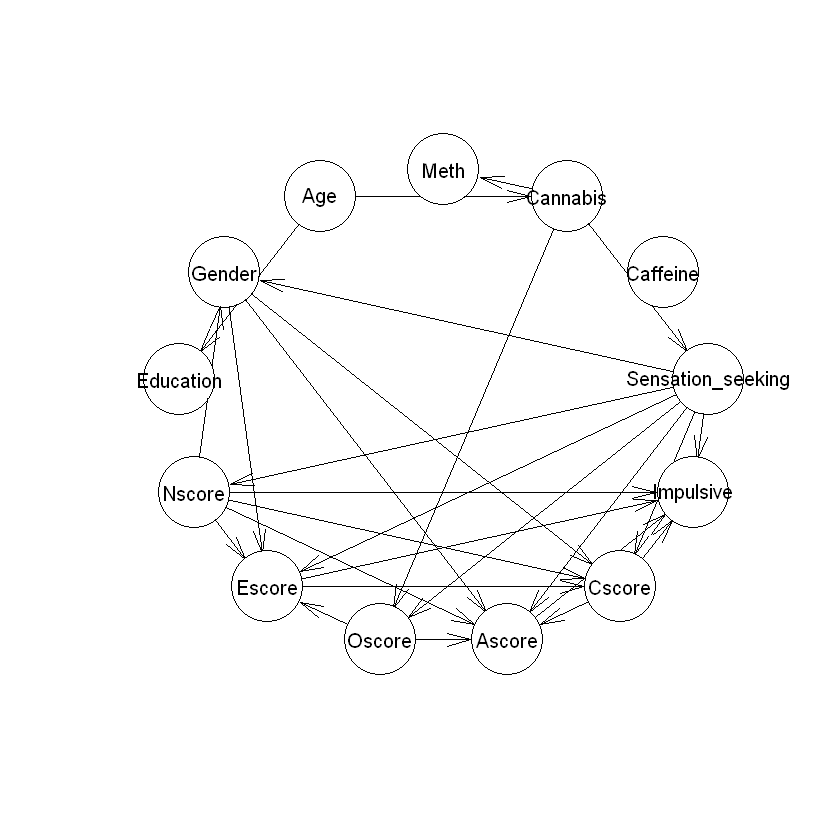

In [4]:
unconstrained_fit <- tabu(df)
plot(unconstrained_fit)

# Inspect fit
unconstrained_fit

# Compute BIC score
print("BIC score unconstrained fit")
score(unconstrained_fit, df)

## Blacklist / whitelist experiments

Using a blacklist we can restrict some connection that are not allowed. E.g. factors that influence age or gender. Also we make tests independent of each other (literature research) and state that the tests and other personality traits cannot be influenced by drugs. 


  Bayesian network learned via Score-based methods

  model:
   [Age][Gender][Escore][Caffeine][Education|Age][Nscore|Gender][Oscore|Age]
   [Ascore|Gender][Cscore|Gender][Cannabis|Age]
   [Impulsive|Gender:Nscore:Escore:Oscore:Ascore:Cscore][Meth|Cannabis]
   [Sensation_seeking|Gender:Escore:Oscore:Ascore:Impulsive]
  nodes:                                 13 
  arcs:                                  18 
    undirected arcs:                     0 
    directed arcs:                       18 
  average markov blanket size:           4.62 
  average neighbourhood size:            2.77 
  average branching factor:              1.38 

  learning algorithm:                    Tabu Search 
  score:                                 BIC (cond. Gauss.) 
  penalization coefficient:              3.770842 
  tests used in the learning procedure:  295 
  optimized:                             TRUE 


[1] "BIC score blacklist fit 1"


[1] -50711.04

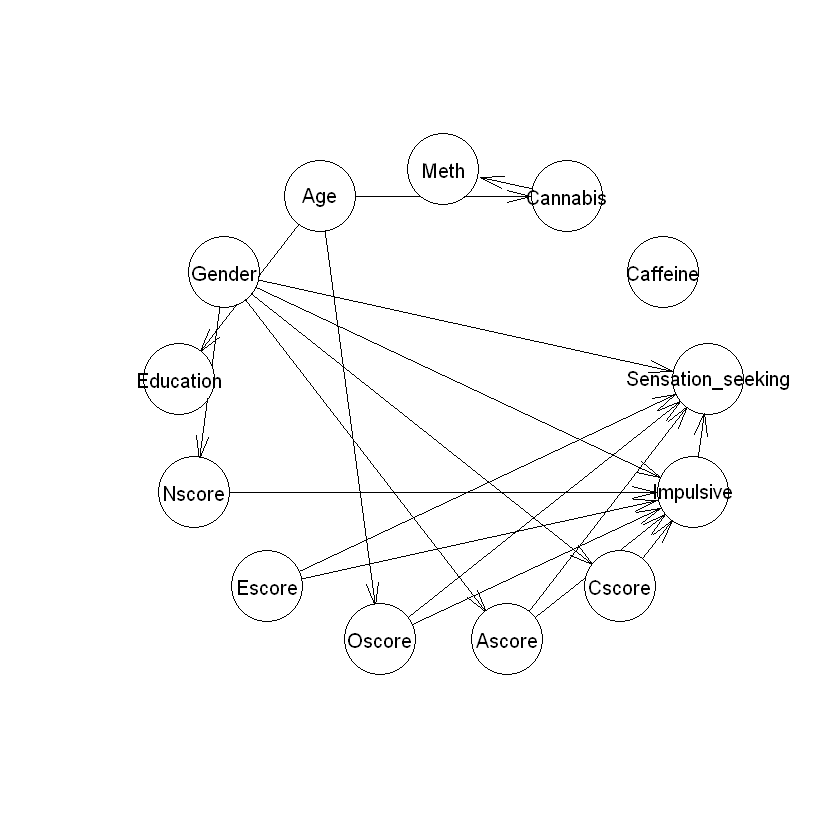

In [5]:
blacklist <- data.frame(
  "from" = c(
    "Gender",
    "Age",
    rep("Escore",6), #1
    rep("Oscore",6), #2
    rep("Ascore",6), #3
    rep("Cscore",6), #4
    rep("Nscore",6), #5
    rep("Sensation_seeking",8), #6
    rep("Impulsive",7), #7
    rep("Education",9), #8
    rep("Caffeine",9), #9
    rep("Cannabis",9), #10
    rep("Meth",9) #11
    
  ),
  "to" = c(
    "Age",
    "Gender",
    "Oscore", "Ascore", "Cscore","Nscore", "Age", "Gender", #Escore
    "Escore", "Ascore", "Cscore","Nscore", "Age", "Gender", #Oscore
    "Escore","Oscore","Cscore","Nscore", "Age", "Gender", #Ascore
    "Escore","Oscore","Ascore","Nscore", "Age", "Gender", #Cscore
    "Oscore","Ascore","Cscore","Escore", "Age", "Gender", #Nscore
    "Oscore","Ascore","Cscore","Escore", "Nscore", "Age", "Gender", "Impulsive", #Sensation_seeking
    "Oscore","Ascore","Cscore","Escore", "Nscore", "Age", "Gender", #Impulsive
    "Oscore","Ascore","Cscore","Escore", "Nscore", "Age", "Gender", "Sensation_seeking", "Impulsive", #Education
    "Oscore","Ascore","Cscore","Escore", "Nscore", "Age", "Gender", "Sensation_seeking", "Impulsive", #Caffeine
    "Oscore","Ascore","Cscore","Escore", "Nscore", "Age", "Gender", "Sensation_seeking", "Impulsive", #Cannabis
    "Oscore","Ascore","Cscore","Escore", "Nscore", "Age", "Gender", "Sensation_seeking", "Impulsive" #Meth
  ))

blacklisted_fit_1 <- tabu(df, blacklist = blacklist)
plot(blacklisted_fit_1)

# Inspect fit
blacklisted_fit_1

# Compute BIC score
print("BIC score blacklist fit 1")
score(blacklisted_fit_1, df)

This approach reduced the number of edges from 27 to 18 (-9). Most edges that were removed were between big-five score tests. Also the BIC score decreased.

For the sake of experimentation, we check what happens when we require the algorithm to create connections from Age and Gender to the 5 personality tests. In assignment 1 these connections we made based on background literature research that was conducted.


  Bayesian network learned via Score-based methods

  model:
   [Age][Gender][Caffeine][Education|Age][Nscore|Age:Gender][Escore|Age:Gender]
   [Oscore|Age:Gender][Ascore|Age:Gender][Cscore|Age:Gender][Cannabis|Age]
   [Impulsive|Gender:Nscore:Escore:Oscore:Ascore:Cscore][Meth|Cannabis]
   [Sensation_seeking|Gender:Escore:Oscore:Ascore:Impulsive]
  nodes:                                 13 
  arcs:                                  24 
    undirected arcs:                     0 
    directed arcs:                       24 
  average markov blanket size:           5.38 
  average neighbourhood size:            3.69 
  average branching factor:              1.85 

  learning algorithm:                    Tabu Search 
  score:                                 BIC (cond. Gauss.) 
  penalization coefficient:              3.770842 
  tests used in the learning procedure:  324 
  optimized:                             TRUE 


[1] "BIC score whitelist fit"


[1] -50833.17

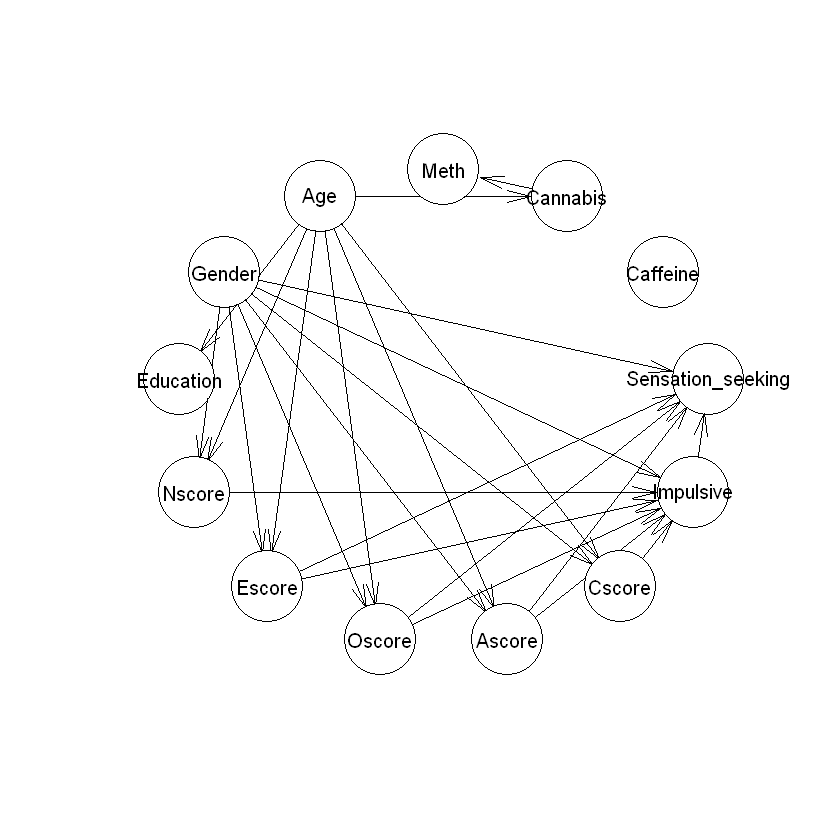

In [6]:
whitelist <- data.frame(
  "from" = c(
    rep("Gender",5),
    rep("Age", 5)
    
  ),
  "to" = c(
    "Oscore", "Ascore", "Cscore","Nscore", "Escore",
    "Oscore", "Ascore", "Cscore","Nscore", "Escore"
  ))

whitelist_fit_1 <- tabu(df, blacklist=blacklist, whitelist=whitelist)
plot(whitelist_fit_1)

# Inspect fit
whitelist_fit_1

# Compute BIC score
print("BIC score whitelist fit")
score(whitelist_fit_1, df)

This increases the number of edges from 19 to 24 (+5) but also leads to a worse BIC score. This is most likely due to the increased complexity of the model. It was decided not to use this whitelist.

## Parameter tuning

### Tabu list size

First we will try what happens if we experiment with the size of the tabu list. The size of the tabu list determines how repetitions of recent moves are restricted to use by the algorithm. The default value is 10.

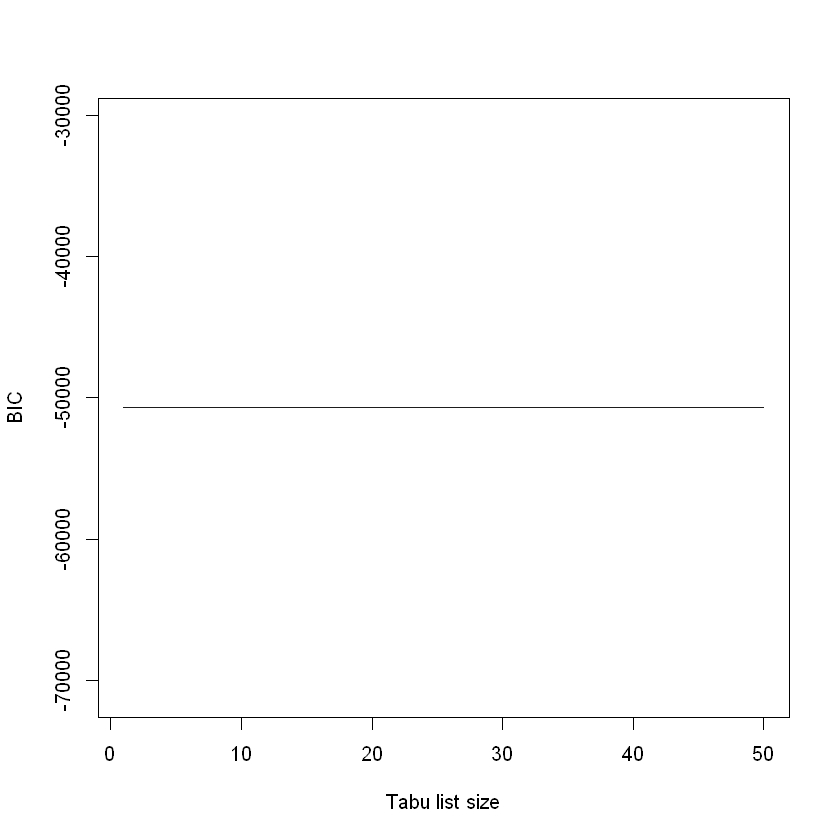

In [7]:
scores = vector()
for (tabu_size in seq(1, 50)) {
  fit <- tabu(df, tabu = tabu_size, blacklist=blacklist)
  scores <- c(scores, score(fit, df))
}
plot(scores, type = "l", xlab="Tabu list size", ylab="BIC", col = "blue")

### Max number of iterations

The size of the tabu list doesn't have any effect on the BIC score that is computed for the different networks. A reason for this can be that the algorithm converges very quick such that restricting moves doesn't have a effect since they aren't considered again. In the next experiment we check what happens with the BIC score if we restrict the maximum number of iterations the algorithm is allowed to do.


  Bayesian network learned via Score-based methods

  model:
   [Age][Gender][Education][Nscore][Escore][Oscore][Ascore][Cscore][Impulsive]
   [Caffeine][Cannabis][Meth][Sensation_seeking|Impulsive]
  nodes:                                 13 
  arcs:                                  1 
    undirected arcs:                     0 
    directed arcs:                       1 
  average markov blanket size:           0.15 
  average neighbourhood size:            0.15 
  average branching factor:              0.077 

  learning algorithm:                    Tabu Search 
  score:                                 BIC (cond. Gauss.) 
  penalization coefficient:              3.770842 
  tests used in the learning procedure:  73 
  optimized:                             TRUE 



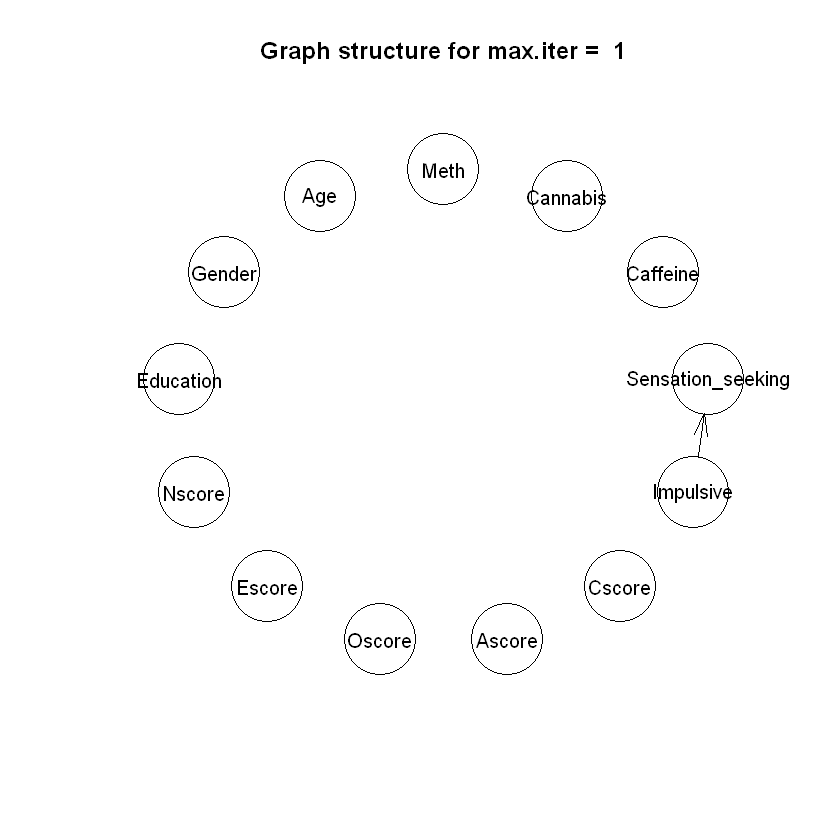


  Bayesian network learned via Score-based methods

  model:
   [Age][Gender][Nscore][Escore][Cscore][Caffeine][Meth][Education|Age]
   [Oscore|Age][Ascore|Gender][Cannabis|Age]
   [Impulsive|Escore:Oscore:Ascore:Cscore][Sensation_seeking|Oscore:Impulsive]
  nodes:                                 13 
  arcs:                                  10 
    undirected arcs:                     0 
    directed arcs:                       10 
  average markov blanket size:           2.46 
  average neighbourhood size:            1.54 
  average branching factor:              0.77 

  learning algorithm:                    Tabu Search 
  score:                                 BIC (cond. Gauss.) 
  penalization coefficient:              3.770842 
  tests used in the learning procedure:  138 
  optimized:                             TRUE 



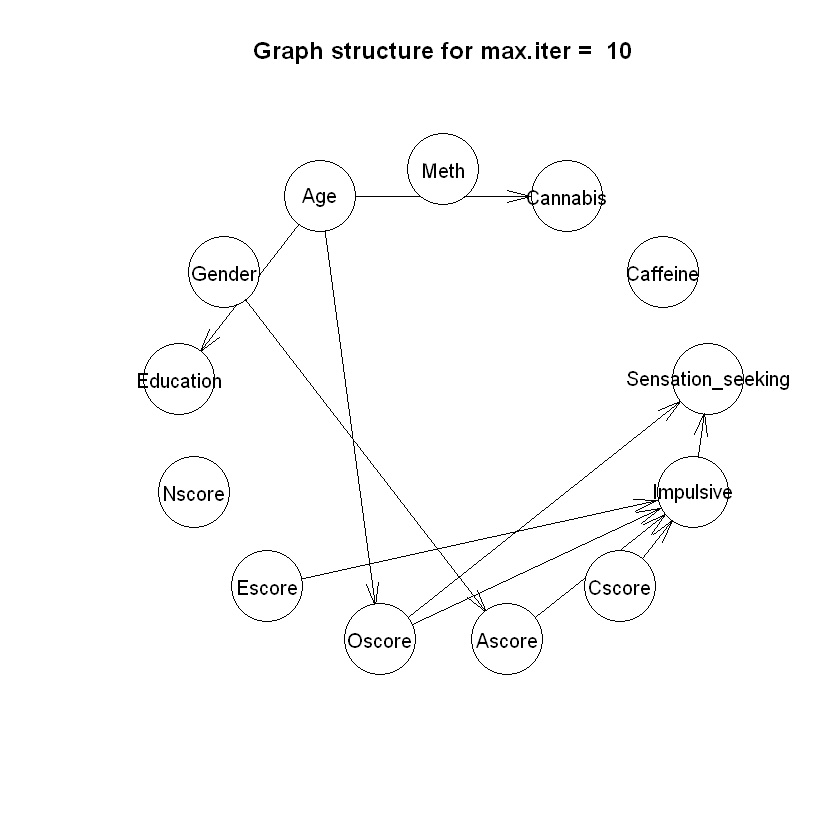


  Bayesian network learned via Score-based methods

  model:
   [Age][Gender][Nscore][Escore][Caffeine][Education|Age][Oscore|Age]
   [Ascore|Gender][Cscore|Gender][Cannabis|Age]
   [Impulsive|Gender:Nscore:Escore:Oscore:Ascore:Cscore][Meth|Cannabis]
   [Sensation_seeking|Gender:Escore:Oscore:Ascore:Impulsive]
  nodes:                                 13 
  arcs:                                  17 
    undirected arcs:                     0 
    directed arcs:                       17 
  average markov blanket size:           4.62 
  average neighbourhood size:            2.62 
  average branching factor:              1.31 

  learning algorithm:                    Tabu Search 
  score:                                 BIC (cond. Gauss.) 
  penalization coefficient:              3.770842 
  tests used in the learning procedure:  190 
  optimized:                             TRUE 



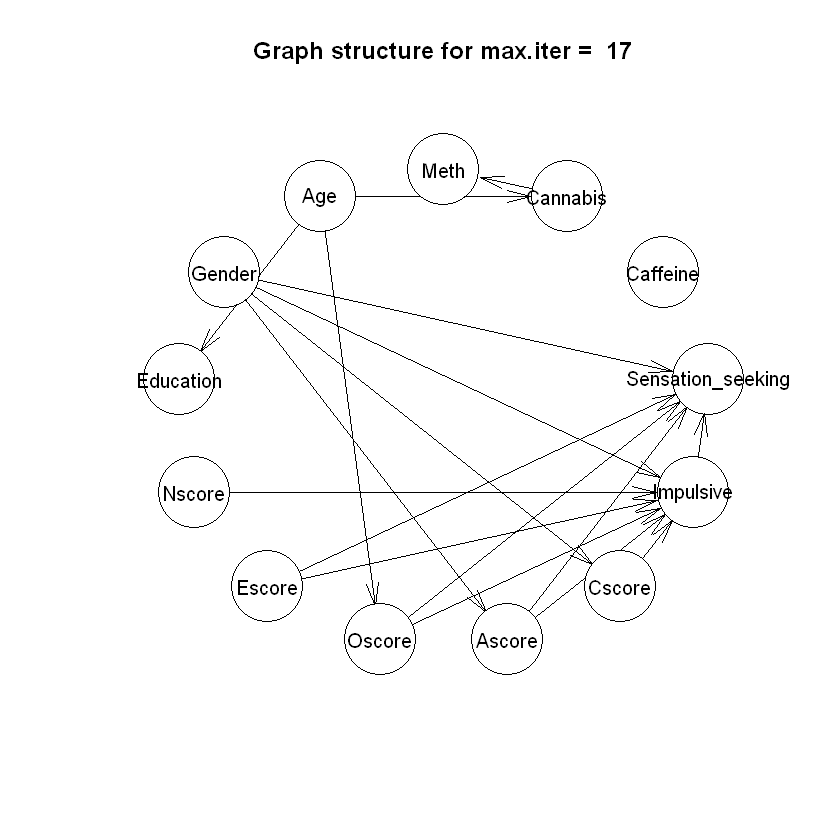

[1] "Obtained network scores:"


[1] -51534.90 -51346.88 -51233.23 -51124.95 -51019.43 -50951.48 -50908.32
 [8] -50879.44 -50850.66 -50816.28 -50787.62 -50767.04 -50746.64 -50733.56
[15] -50722.17 -50714.44 -50711.95 -50711.04 -50711.04 -50711.04 -50711.04
[22] -50711.04 -50711.04 -50711.04 -50711.04

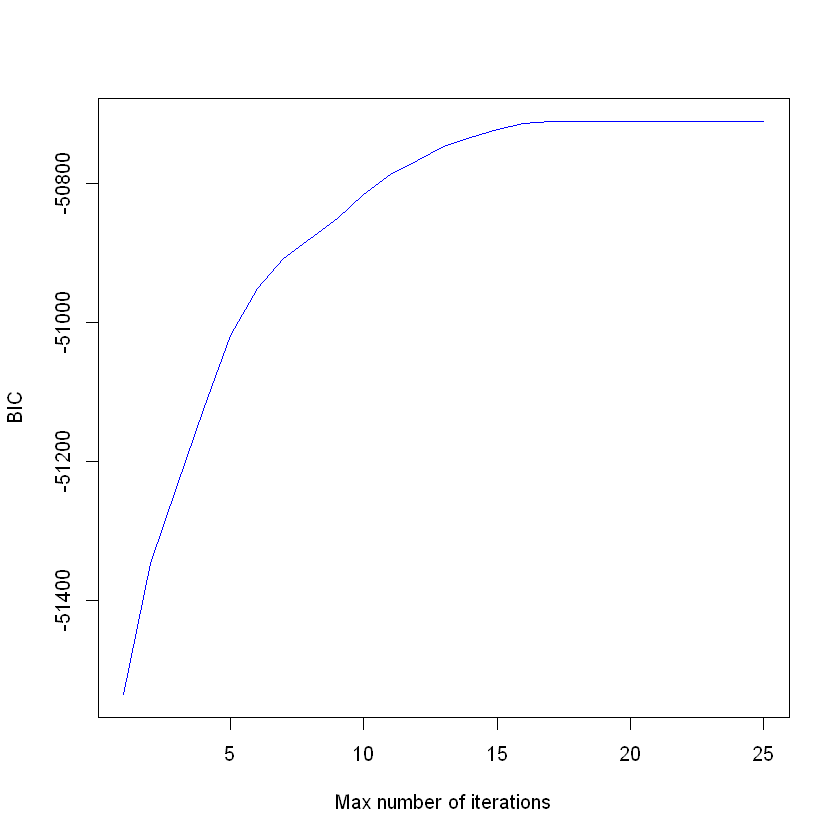

In [8]:
scores = vector()

plots <- c(1, 10, 17)
for (max_iter in seq(1, 25)) {
  fit <- tabu(df, max.iter = max_iter, blacklist=blacklist)
    
  if (max_iter %in% plots) {
      plot(fit, main=paste("Graph structure for max.iter = ", max_iter))
      print(fit)
  }
  
  # Store the score for visualization
  scores <- c(scores, score(fit, df))
}
plot(scores, type = "l", xlab="Max number of iterations", ylab="BIC", col = "blue")

print("Obtained network scores:")
scores

As can be seen above the number of iterations has a relatively high impact on the BIC score of the network. This is expected since it is unlikely that the network will obtain its optimal score after only a few iterations. Despite this, the network converges after 17 iterations. This can also be a reason why changing the tabu list size has no effect on the performance of the network. Graphs for different maximum number of iterations can be seen above.

The final parameter we experimented with is the  k-parameter used by the BIC scoring metric. This parameter determines how much the graph is penalized for complexity. In the obtained graphs above it had a value of ≈ 3.77. Below we test a variety of k-values to see how it affects the obtained graph structures.

Warning message in check.penalty(k = extra.args$k, network = network, data = data, :
"using BIC with a non-standard penalty k = 1."Warning message in check.penalty(k = extra.args$k, network = network, data = data, :
"using BIC with a non-standard penalty k = 3."Warning message in check.penalty(k = extra.args$k, network = network, data = data, :
"using BIC with a non-standard penalty k = 5."

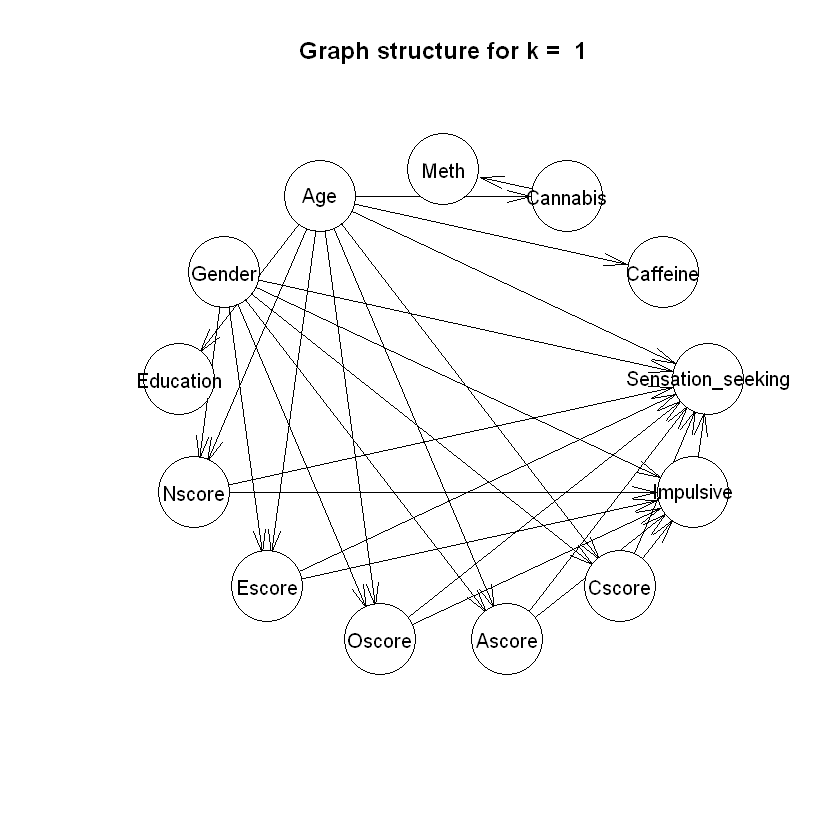

Warning message in check.penalty(k = extra.args$k, network = network, data = data, :
"using BIC with a non-standard penalty k = 7."

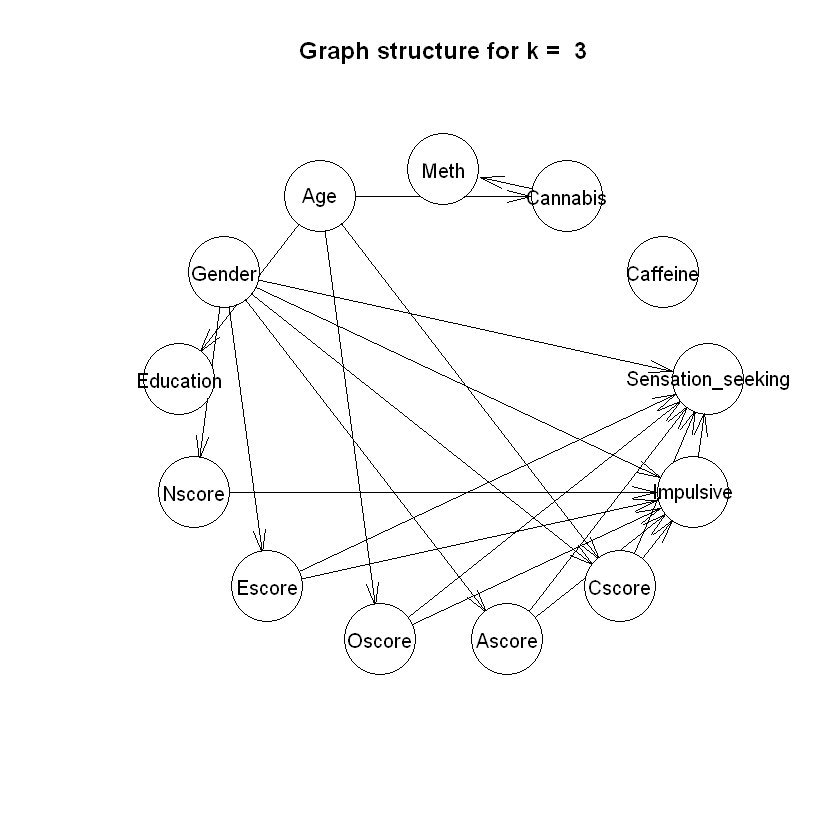

Warning message in check.penalty(k = extra.args$k, network = network, data = data, :
"using BIC with a non-standard penalty k = 9."

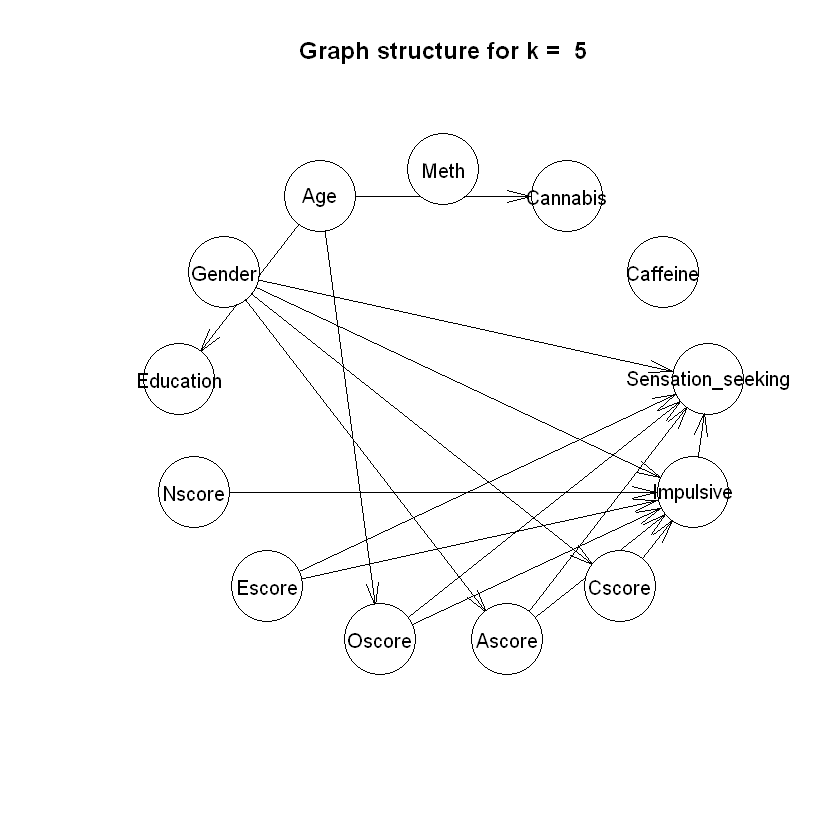

Warning message in check.penalty(k = extra.args$k, network = network, data = data, :
"using BIC with a non-standard penalty k = 11."

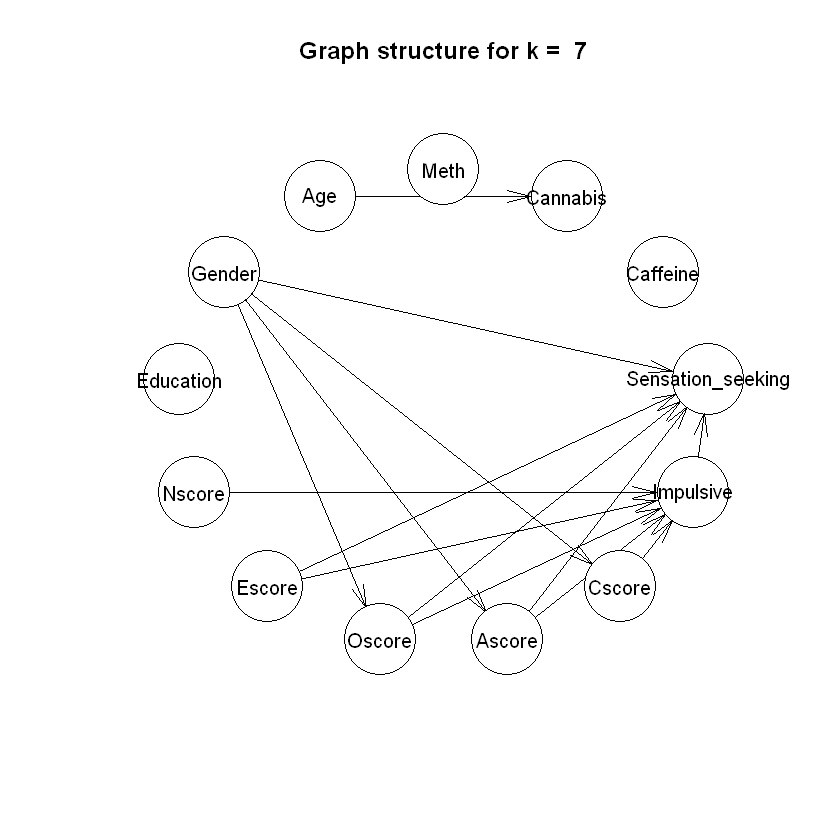

Warning message in check.penalty(k = extra.args$k, network = network, data = data, :
"using BIC with a non-standard penalty k = 13."

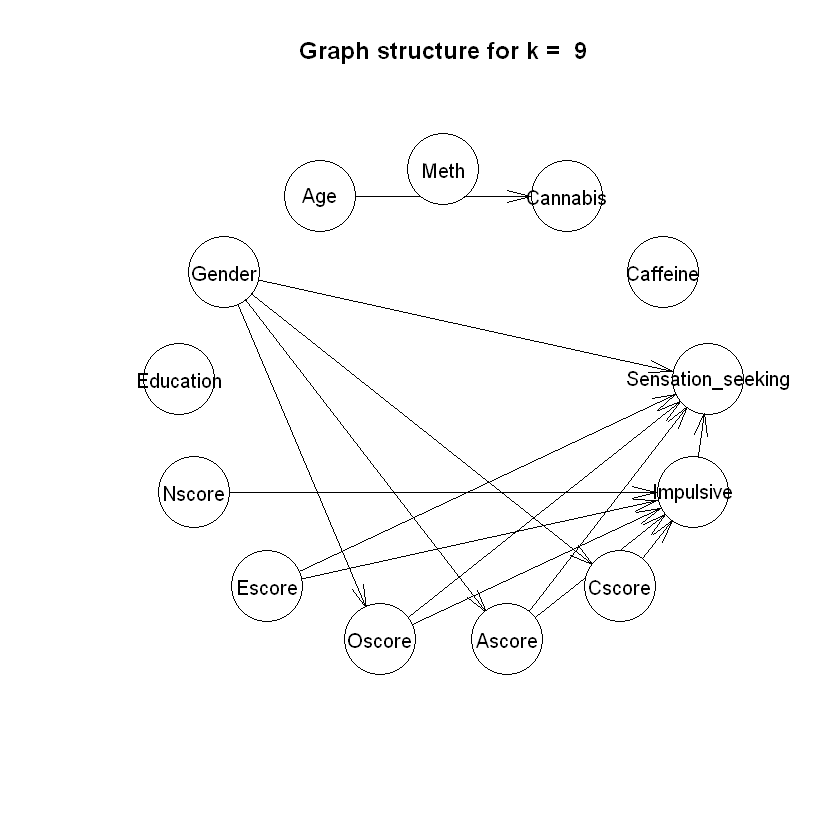

Warning message in check.penalty(k = extra.args$k, network = network, data = data, :
"using BIC with a non-standard penalty k = 15."

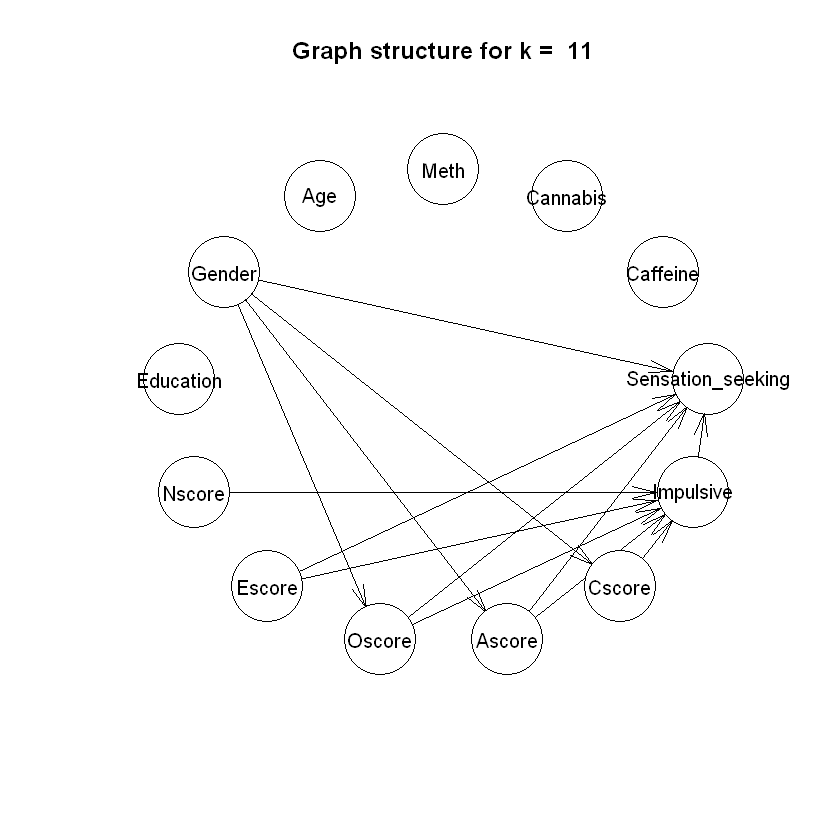

Warning message in check.penalty(k = extra.args$k, network = network, data = data, :
"using BIC with a non-standard penalty k = 17."

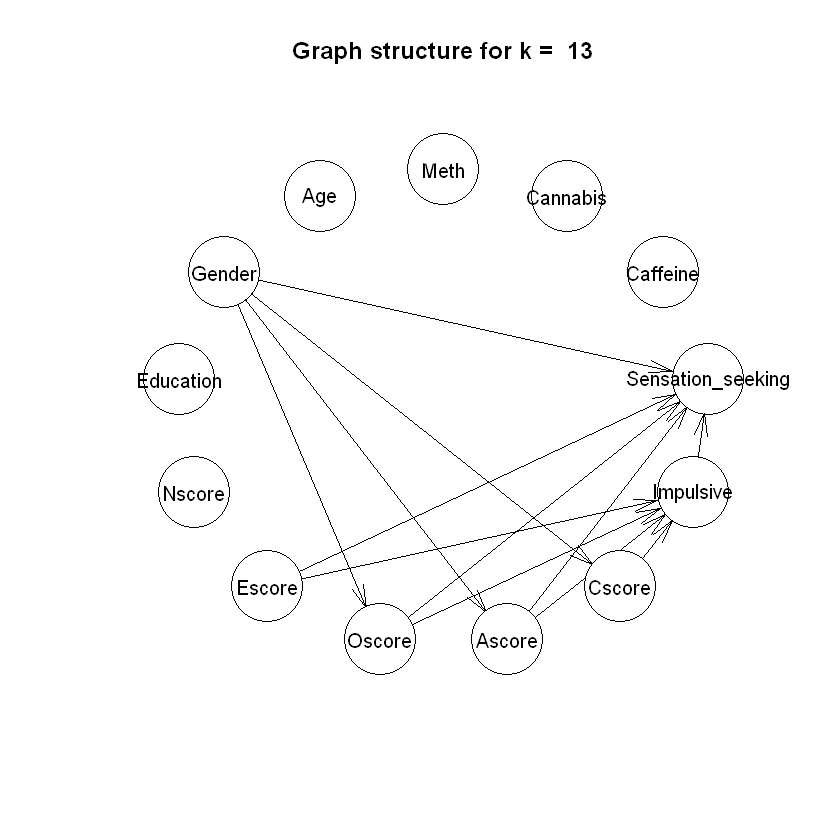

Warning message in check.penalty(k = extra.args$k, network = network, data = data, :
"using BIC with a non-standard penalty k = 19."

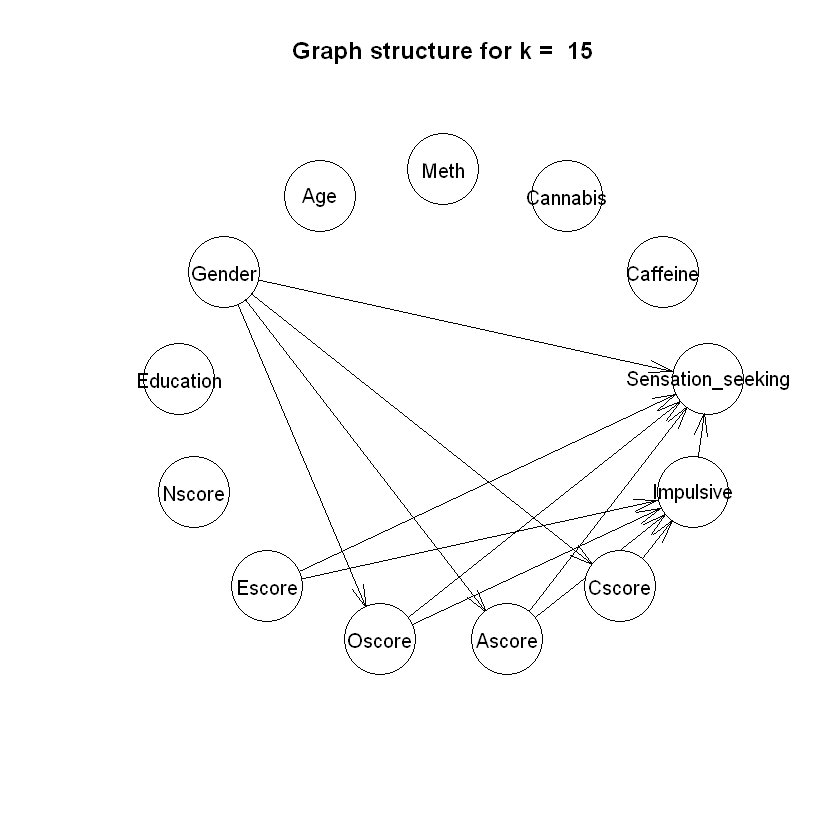

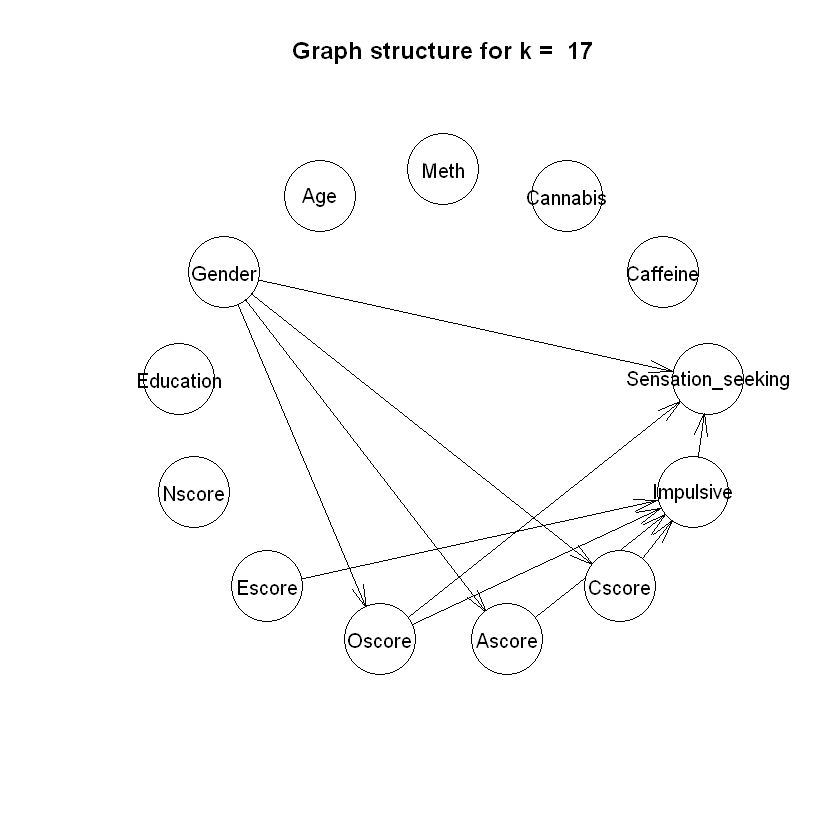

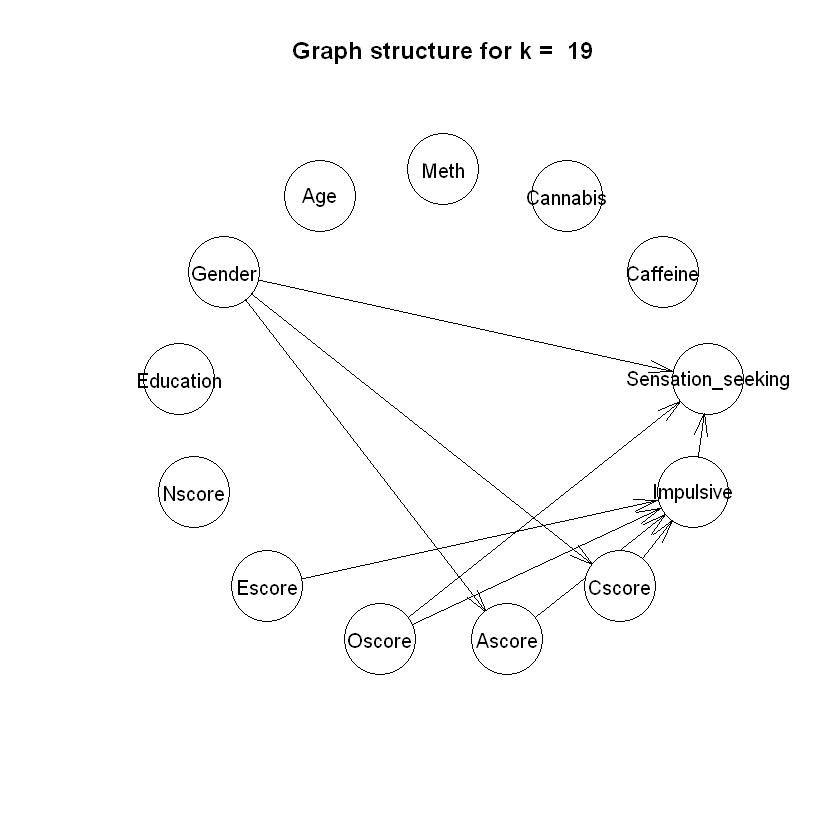

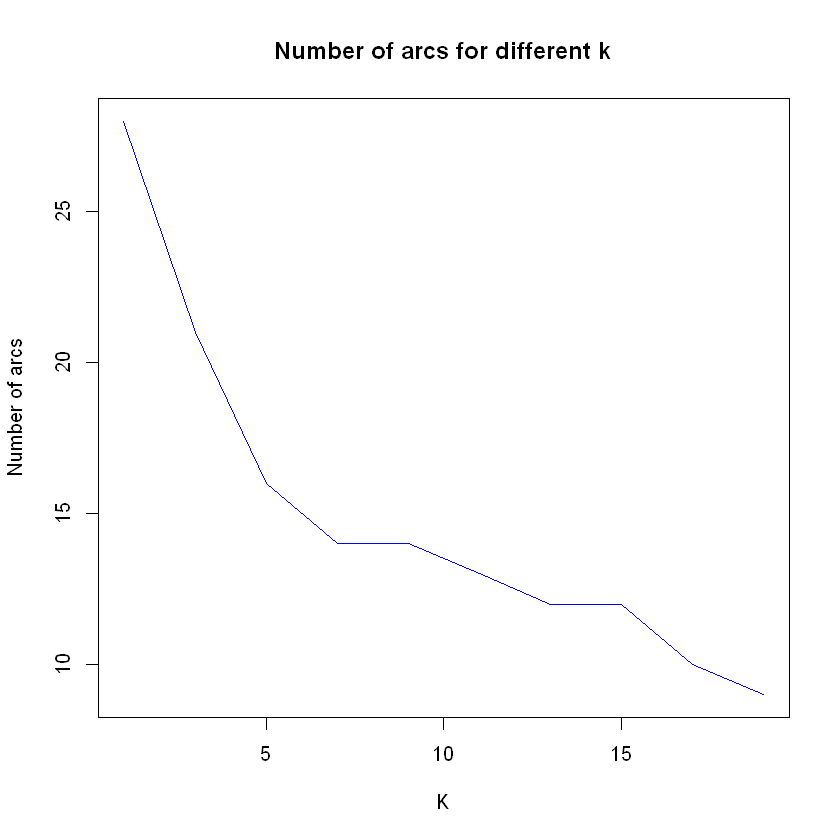

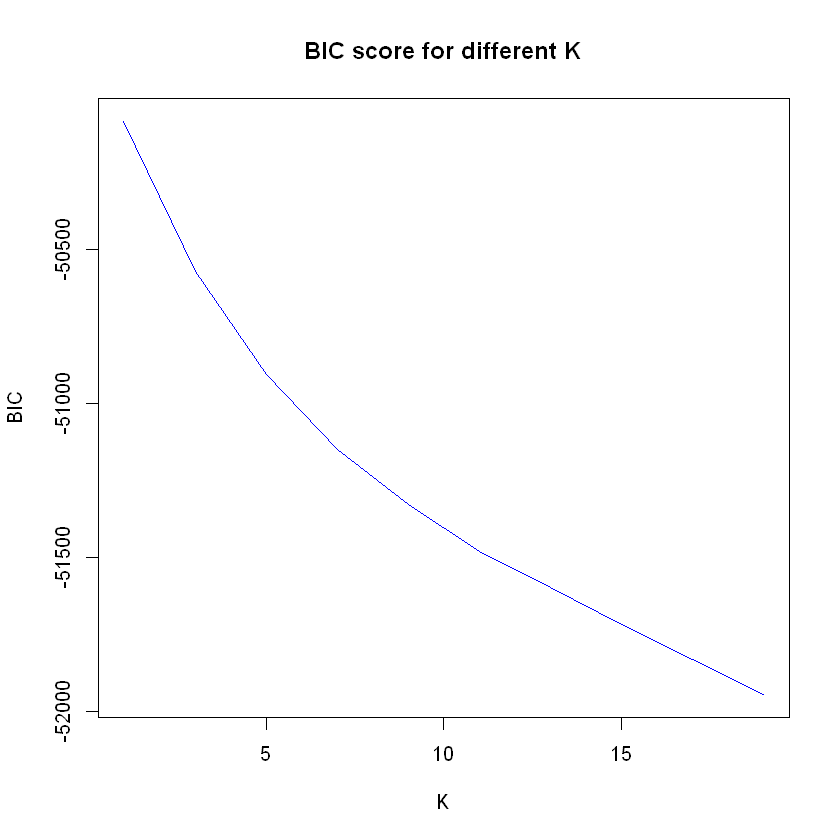

In [9]:
scores = vector()
arcs = vector()
for (pen_cof in seq(1, 20, by = 2)) {
  fit <- tabu(df, k = pen_cof, blacklist=blacklist)
  plot(fit, main=paste("Graph structure for k = ", pen_cof))  
    
  # Store the score and number of arcs for visualization  
  scores <- c(scores, score(fit, df))
  arcs <- c(arcs, nrow(arcs(fit)))
}

plot(x=seq(1, 20, by = 2), y=arcs, type = "l", xlab="K", ylab="Number of arcs", col = "blue", main="Number of arcs for different k")
plot(x=seq(1, 20, by = 2), y=scores, type = "l", xlab="K", ylab="BIC", col = "blue", main="BIC score for different K")

In the graph structures and plots above can be seen that using a higher k results in less arcs and a decreasing (getting more negative) BIC score. A decreasing number of arcs was expected because more penalization leads to a less complex graph which is established having less arcs. The decreasing BIC score was also expected because the penalization becomes stronger using a larger value for k. Because k scales faster than the number of arcs decreases we see a decreasing BIC score.

## Path coefficients

Plot coordinates for graph not supplied! Generating coordinates, see ?coordinates for how to set your own.


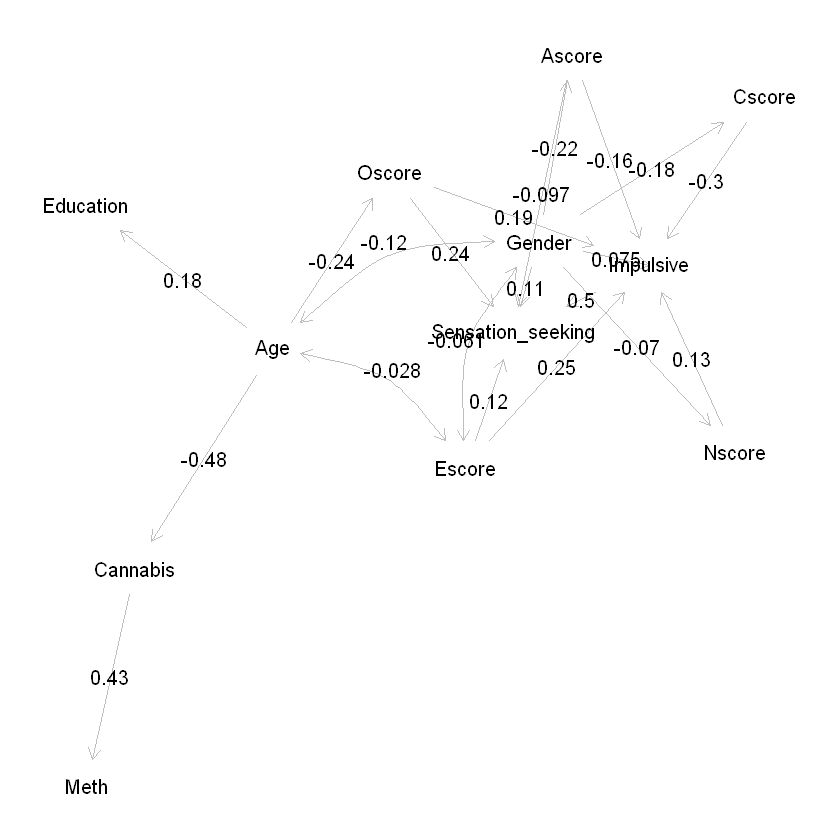

In [10]:
network <- "dag { Age Gender Escore Caffeine Education Nscore Oscore Ascore Cscore Cannabis Impulsive Meth Sensation_seeking Age -> Education Gender -> Nscore Age -> Oscore Gender -> Ascore Gender -> Cscore Age -> Cannabis Gender -> Impulsive Nscore -> Impulsive Escore -> Impulsive Oscore -> Impulsive Ascore -> Impulsive Cscore -> Impulsive Cannabis -> Meth Gender -> Sensation_seeking Escore -> Sensation_seeking Oscore -> Sensation_seeking Ascore -> Sensation_seeking Impulsive -> Sensation_seeking }"

g1 <- dagitty(network)

# Create correlation matrix using lavaan to calculate the path coefficients
M <- lavCor(df)
model1 <- toString(g1,"lavaan")
msem <- lavaan(model1, sample.cov=M, sample.nobs=nrow(df),estimator="ML", auto.var=TRUE, fixed.x = FALSE)
fg <- lavaanToGraph(msem, digits = 2)
plot(fg, show.coefficients = TRUE)